In [152]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pickle
import csv, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os
import winsound
import re 
from IPython import display
import importlib
import html, string
import preprocess_twitter
from nltk.tokenize import sent_tokenize, TreebankWordTokenizer

In [151]:
importlib.reload(preprocess_twitter);

In [60]:
with open('config.json') as json_config_file:
    user_config = json.load(json_config_file)
    data_path = user_config.get('data_path', os.getcwd())

change user config

In [61]:
# user_config = {}
# user_config['data_path'] = r"<your_path_here>"

# with open('config.json', 'w') as json_config_file:
#     json.dump(user_config, json_config_file)

In [62]:
vocab_size=int(1.2e6)
embedding_dim=200
assumed_max_length=70

File paths

In [63]:
word_dict_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_dict.pickle"), 'rb')
word_dict = pickle.load(word_dict_file)
word_dict2_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_dict2.pickle"), 'rb')
word_dict2 = pickle.load(word_dict2_file)

In [64]:
word_embedding_file = open(os.path.join(data_path, r"d" + str(embedding_dim) +"_word_embedding", "word_embeddings_ndarray.pickle"), 'rb')
np_embedding = pickle.load(word_embedding_file)

## Preprocessing tweets

In [118]:
def remove_rt(txt):
    txt = txt.replace('RT','')
    return txt
    
def remove_link(txt):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', txt)
    for i in range(len(urls)):
        txt=txt.replace(urls[i],'')
    return txt
    
def remove_mentions(txt):
    mentions = re.findall(r'(?<=\W)[@]\S*', txt)
    for i in range(len(mentions)):
        txt=txt.replace(mentions[i],'')
    return txt
    
def remove_repeated_chars(txt):
    repeated_char= re.findall(r'((\w)\2{2,})',txt)
    for i  in range(len(repeated_char)):
        txt = txt.replace(repeated_char[i][0],repeated_char[i][1])
    return txt
    
def modify_lowercase_uppercase(txt):
    txt = txt.split(' ')
    for j in range(len(txt)):
        if not(txt[j].isupper()) and not(txt[j].islower()):
            txt[j] = txt[j].lower()
    tweet = ' '.join(txt )
    return tweet

def modify_all_lowercase(txt):
    return txt.lower()

def unescape_html(txt):
    return html.unescape(txt)

def split_punctuations(txt):
    txt = re.sub(r" *([^\w ']|( '|' |^'|'$)) *", r' \1 ', txt)
#     txt=re.sub(r"(((^|(?<=\s))')|('($|(?=\s))))", r' \1 ', sub0)
#     txt=re.sub(r" *([^\w ]) *", r' \1 ', txt)
    return txt

def split_emojis(txt):
    emojis='[\U0001F601-\U0001F64F\U00002702-\U000027B0\U0001F680-\U0001F6C0\U000024C2-\U0001F251\U0001F600-\U0001F636\U0001F681-\U0001F6C5\U0001F30D-\U0001F567]'
    return re.sub(r" *({}) *".format(emojis), r' \1 ', txt)

def replace_emojis(txt):
    txt=re.sub('[\U0000FE00-\U0000FE0F]', '', txt) #remove variation selectors
    txt=re.sub('[\U0001F3FB-\U0001F3FF]', '', txt) #remove color tones
    smile_ug = '[\U0001F603\U0001F604\U0001F600]'
    lolface_ug = '[\U0001F602\U0001F606]'
    sadface_ug = '[\U0001F614\U0001F616\U0001F622\U0001F625\U0001F629\U0001F62D\U0001F630\U0001F63F]'
    neutralface_ug = '[\U0001F610]'
    heart_ug = '[\U0001F60D\U0001F618\U0001F63B\U00002764\U0001F491-\U0001F49F]'
    txt = re.sub(smile_ug, " ᐸsmileᐳ ", txt)
    txt = re.sub(lolface_ug, " ᐸlolfaceᐳ ", txt)
    txt = re.sub(sadface_ug, " ᐸsadfaceᐳ ", txt)
    txt = re.sub(neutralface_ug, " ᐸneutralfaceᐳ ", txt)
    txt = re.sub(heart_ug, " ᐸheartᐳ ", txt)
    return txt

def split_others(txt):
    emojis='[\U0001F601-\U0001F64F\U00002702-\U000027B0\U0001F680-\U0001F6C0\U000024C2-\U0001F251\U0001F600-\U0001F636\U0001F681-\U0001F6C5\U0001F30D-\U0001F567]'
    txt = re.sub(r" *(( '|' |^'|'$)|[’.+…”“*]|{}) *".format(emojis), r' \1 ', txt)
    return txt

def multiclass_sentiment(line):
    sentiment_list = []
    for i in line[2:]:
        if i == '' or not i.isdigit() : continue
        sentiment_list.append(int(i) - 1)
    return sentiment_list

tokenizer = TreebankWordTokenizer()
def tweets_list_final(file_name, encoding):
    tweets_file = open(file_name,"r",encoding=encoding)
    tweets_csv_reader = csv.reader(tweets_file)
    init_tweet=np.array([-2 for _ in range(assumed_max_length)])
    for line in tweets_csv_reader:
        #if line == [] : continue
        if len(line)<2 : continue
        try :
            sent = int(line[2])
            sentiments.append(sent - 1)
            sentiments_lists.append(multiclass_sentiment(line)) 
            tweet_np = np.copy(init_tweet)
            tweet = line[1]
            tweets_unprocessed.append(tweet)
            
#             tweet1 = remove_rt(tweet)
#             tweet1 = remove_link(tweet1)
#             tweet1 = remove_mentions(tweet1)
#             tweet1 = remove_repeated_chars(tweet1)
# #             tweet1 = modify_lowercase_uppercase(tweet1) 
#             tweet1 = modify_all_lowercase(tweet1)
#             tweet1 = unescape_html(tweet1)
#             tweet1 = split_punctuations(tweet1)
#             tweet1 = split_punctuations(tweet1)
#             tweet = tweet1.split()
        
            tweet1=preprocess_twitter.tokenize(tweet)
            tweet1 = unescape_html(tweet1)
            tweet1 = split_punctuations(tweet1)
            tweet1 = split_emojis(tweet1)
            tweet1 = replace_emojis(tweet1)
#             tweet1 = split_others(tweet1)
            tweet1= tokenizer.tokenize(tweet1)
            tweet = tweet1

            tweets.append(tweet)
            for i in range(len(tweet)) :
#                 tweet_np[i] = word_dict.get(tweet[i],-1)
                tweet_np[i] = word_dict2.get(tweet[i],-1)
                if(tweet_np[i]==-1 and (tweet[i]==' ' or tweet[i]=='T')): print(tweet1)

            tweets_indexed.append(tweet_np)
        except ValueError as err: pass
    tweets_file.close()

In [119]:
tweets = []
tweets_unprocessed = []
tweets_indexed = []
sentiments = []
sentiments_lists = []
tweets_list_final(os.path.join(data_path, "data_set0.csv"), "utf-8-sig")
tweets_list_final(os.path.join(data_path, "data_set1.csv"), "utf-8-sig")
#tweets_list_final(os.path.join(data_path, "data_set_a0.csv"), "utf-8-sig")

In [132]:
tweets_np = np.array(tweets_indexed)
sents_np = np.array(sentiments, np.int16)

In [121]:
unmatched_words=tweets_np==-1
all_words=tweets_np>=-1
print('unmatched words:', round(np.count_nonzero(unmatched_words)/np.count_nonzero(all_words), 5))

unmatched words: 0.02241


In [122]:
unknown_words = set()
unknown_words_l = []
for i in range(tweets_np.shape[0]):
    for j in range(tweets_np.shape[1]):
        if tweets_np[i,j]==-1:
            unknown_words.add(tweets[i][j])
            unknown_words_l.append(tweets[i][j])
print('Unknown words:')
# unknown_words
unknown_words_counts = []
unknown_words_dl = list(unknown_words)
for i in range(len(unknown_words_dl)):
    unknown_words_counts.append([unknown_words_l.count(unknown_words_dl[i]), unknown_words_dl[i]])
sorted(unknown_words_counts, reverse=True)

Unknown words:


[[21, '🔥'],
 [15, '🎉'],
 [14, '💀'],
 [12, '👌'],
 [12, '🏾'],
 [12, '🎄'],
 [11, '💯'],
 [10, '🏽'],
 [9, '😅'],
 [9, '🏼'],
 [8, '🙄'],
 [8, '🌹'],
 [7, '🤔'],
 [7, '🙏'],
 [7, '😎'],
 [7, '👏'],
 [6, '😊'],
 [6, '🏻'],
 [6, '🎅'],
 [6, '\u200d'],
 [6, "y'all"],
 [6, 'daysoflionheart'],
 [5, '🙌'],
 [5, '🙃'],
 [5, '😴'],
 [5, '😫'],
 [5, '😡'],
 [5, '😋'],
 [5, '💪'],
 [4, '🔴'],
 [4, '👍'],
 [4, '👀'],
 [4, '🐶'],
 [4, '🎈'],
 [4, '🎁'],
 [4, '🌻'],
 [4, 'sconesofireland'],
 [3, '🙈'],
 [3, '😒'],
 [3, '😁'],
 [3, '💋'],
 [3, '🎊'],
 [3, '🌷'],
 [3, '🌯'],
 [3, '🌟'],
 [3, 'dismantlers'],
 [3, 'brexit'],
 [3, 'bigolive'],
 [2, '🤘'],
 [2, '🤗'],
 [2, '🙂'],
 [2, '😧'],
 [2, '😦'],
 [2, '😤'],
 [2, '😛'],
 [2, '😏'],
 [2, '😉'],
 [2, '📷'],
 [2, '💦'],
 [2, '💐'],
 [2, '💄'],
 [2, '👸'],
 [2, '👩'],
 [2, '👧'],
 [2, '👣'],
 [2, '🎮'],
 [2, '🎥'],
 [2, '🍀'],
 [2, '🌌'],
 [2, '🇺'],
 [2, '🇸'],
 [2, '🇭'],
 [2, 'ी'],
 [2, 'ा'],
 [2, 'savvies'],
 [2, 'offcampus'],
 [2, 'hwarang'],
 [2, 'holiplay'],
 [2, 'flightlog'],
 [2, 'fdlx'],
 [2, 'bluehand'

In [123]:
for i in range(assumed_max_length):
    if np.all(tweets_np[:,i]==-2):
        max_length=i+1; break; 
print('max_length:', max_length)

max_length: 57


In [124]:
tweets_embedded = np.zeros((tweets_np.shape[0], tweets_np.shape[1], embedding_dim))
for i in range(tweets_np.shape[0]):
    tweet=tweets_np[i]
    for j in range(max_length):
        word_index=tweets_np[i,j]
        if word_index == -1: continue
        if word_index == -2: break
        tweets_embedded[i,j]=np_embedding[word_index]

In [153]:
print('data set size:', len(sents_np))
print('sent counts:', np.bincount(sents_np))

data set size: 1649
sent counts: [313 223 167 526 148  73  44 155]


# Graph

In [126]:
num_units = 200
num_layers = 1
batch_size = 20
classes = 8
num_steps = max_length

In [127]:
tf.reset_default_graph()
tf.set_random_seed(0)
# embedding = tf.Variable(tf.constant(0, dtype=tf.float16, shape=(vocab_size, embedding_dim)), trainable=False, name='embedding')
inputs = tf.placeholder(tf.float32, (batch_size, num_steps, embedding_dim))
targets = tf.placeholder(tf.int32, (batch_size,))

softmax_w = tf.Variable(tf.random_uniform((num_units, classes), 0.0001, 0.001))
softmax_b = tf.Variable(tf.random_uniform((classes,), 0.0001, 0.001))

cell = rnn.BasicLSTMCell(num_units)
tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=.7)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
all_outputs, final_states = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
outputs = all_outputs[:,-1]

targets_oh = tf.one_hot(targets, classes, on_value=1, off_value=0)

logits = tf.matmul(outputs, softmax_w) + softmax_b
probs = tf.nn.softmax(logits)
results = tf.argmax(probs, 1)

# losses=tf.reduce_sum(tf.square(tf.subtract(tf.cast(targets_oh, tf.float16), tf.cast(probs, tf.float16))))
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)

opt = tf.train.AdamOptimizer()
opt_op = opt.minimize(losses)

fw=tf.summary.FileWriter('TFSums', tf.get_default_graph())
fw.flush()
# graph_runs = 0

# Session

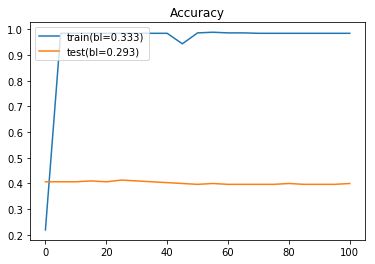

In [161]:
iters=100; max_train=1200; max_test = 300
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# saver = tf.train.Saver()
# saver.restore(sess, os.path.join(data_path, "d"+ str(embedding_dim), "_word_embedding", "TF_Variables")

train_baseline=np.round(np.max(np.bincount(sents_np[:max_train]))/max_train, 3)
test_baseline=np.round(np.max(np.bincount(sents_np[max_train:max_train+max_test]))/max_test, 3)

x_axis=[]

all_accs = np.zeros(iters)
all_accs_sampled = np.zeros(iters//5+1)
tests_accs = np.zeros(iters//5+1)
for i in range(iters):
    checkpoint = i if i%5 == 0 or i==iters-1 else None
    iter_train_result = np.zeros(max_train); final_train_probs = np.zeros((max_train, classes))
    iter_test_result = np.zeros(max_test); final_test_probs = np.zeros((max_test, classes))
    for j in range(int(max_train/batch_size)):
        np_inputs = tweets_embedded[j*batch_size:(j+1)*batch_size, :num_steps]
        np_targets = sents_np[j*batch_size:(j+1)*batch_size]
        if checkpoint and i==iters-1:
            _, np_probs, np_results = sess.run([opt_op, probs, results], feed_dict={inputs: np_inputs, targets: np_targets})
            iter_train_result[j*batch_size:(j+1)*batch_size] = np_results
            final_train_probs[j*batch_size:(j+1)*batch_size] = np_probs
        elif checkpoint:
            _, np_results = sess.run([opt_op, results], feed_dict={inputs: np_inputs, targets: np_targets})
            iter_train_result[j*batch_size:(j+1)*batch_size] = np_results
        else:
            _ = sess.run([opt_op], feed_dict={inputs: np_inputs, targets: np_targets})

    if checkpoint is None : continue
    if i==iters-1: checkpoint+=1
    checkpoint//=5
#     checks = iter_train_result==sents_np[:max_train] 
    checks = np.fromiter(map(lambda i,j :i in j, iter_train_result, sentiments_lists[:max_train]), dtype=np.bool)
    all_accs[i] = np.count_nonzero(checks)/checks.size
    
    #update plot
    all_accs_sampled[checkpoint] = all_accs[i]
    x_axis.append(checkpoint*5)
#     sys.stdout.write('\r'); sys.stdout.write('      '); sys.stdout.write('\r')
#     print(i, end='')
    plt.gca().cla() 
    plt.plot(x_axis,all_accs_sampled[:(checkpoint)+1], label="train(bl=" + str(train_baseline) + ")")
    for test in range(int(max_test/batch_size)):
        np_test_inputs = tweets_embedded[max_train + (test*batch_size):max_train + ((test+1)*batch_size), :num_steps]
        np_test_targets = sents_np[max_train + (test*batch_size):max_train + ((test+1)*batch_size)]
        if i==iters-1:
            np_test_results, np_test_probs = sess.run([results, probs], feed_dict={inputs:  np_test_inputs, targets: np_test_targets})
            final_test_probs[(test*batch_size):((test+1)*batch_size)] = np_test_probs
        else:
            np_test_results, = sess.run([ results], feed_dict={inputs:  np_test_inputs, targets: np_test_targets})
        iter_test_result[(test*batch_size):((test+1)*batch_size)] = np_test_results
#     checks = iter_test_result==sents_np[max_train:max_train + max_test] 
    checks = np.fromiter(map(lambda i,j :i in j, iter_test_result, sentiments_lists[max_train:max_train + max_test]), dtype=np.bool)
    tests_accs[checkpoint] = np.count_nonzero(checks)/checks.size
    plt.plot(x_axis,tests_accs[:(checkpoint)+1],label="test(bl=" + str(test_baseline) + ")")
    plt.title('Accuracy')
    plt.legend(loc='upper left')
    display.display(plt.gcf())
    display.clear_output(wait=True)
# sys.stdout.write('\r'); sys.stdout.write('      '); sys.stdout.write('\r')

winsound.Beep(2500,500)

In [162]:
print('train_acc:', all_accs_sampled[-1], '  test_acc:', tests_accs[-1])

train_acc: 0.985   test_acc: 0.4


In [163]:
print('train_acc:', max(all_accs_sampled), '  test_acc:', max(tests_accs))

train_acc: 0.989166666667   test_acc: 0.413333333333


### Wrong results

In [164]:
sent_map=['Happy','Love','Hopeful','Neutral','Angry','Hopeless','Hate','Sad']
for i in range(max_test):
          if checks[i]==False:
            print(' '.join(tweets[max_train+i]), '\n>' , sent_map[int(iter_test_result[i])], ">>", [sent_map[j] for j in sentiments_lists[max_train+i]], '>>>', [float('{:.3}'.format(k)) for k in final_test_probs[i]])

dogs are insane 😒 🖕 🏻 
> Hopeless >> ['Sad', 'Angry', 'Hate'] >>> [7.18e-07, 3.01e-07, 4.55e-05, 0.000329, 1.01e-05, 0.979, 0.021, 8.06e-05]
rt ᐸallcapsᐳ ᐸuserᐳ : raiders making the playoffs is the best thing that happened this year . 
> Angry >> ['Happy'] >>> [0.0144, 6.5e-07, 0.00268, 0.21, 0.77, 9.95e-05, 0.00197, 0.00097]
rt ᐸallcapsᐳ ᐸuserᐳ : stop coming on my twitter shawty looking for clues ᐸheartᐳ aint gone know if im single or taken dont get confused 
> Angry >> ['Neutral'] >>> [4.06e-05, 1.65e-07, 2.83e-05, 0.00012, 0.997, 1.35e-05, 0.00149, 0.000935]
your mcm treats you like shit but gets smacked on the back of his head by his homeboys 💀 
> Happy >> ['Hate'] >>> [1.0, 9.22e-06, 1.53e-07, 9.25e-07, 6.48e-08, 2.2e-09, 4.59e-09, 6.45e-05]
want to work at cvs ᐸallcapsᐳ health ? we 're ᐸhashtagᐳ hiring in ᐸhashtagᐳ sant clarita , ca ᐸallcapsᐳ ! click for details : ᐸurlᐳ ᐸhashtagᐳ job ᐸhashtagᐳ healthcare ᐸhashtagᐳ jobs 
> Neutral >> ['Hopeful'] >>> [2.1e-07, 9.31e-09, 1.05e-06, 1

unprocessed tweets

In [115]:
sent_map=['Happy','Love','Hopeful','Neutral','Angry','Hopeless','Hate','Sad']
for i in range(max_test):
          if checks[i]==False:
            print(tweets_unprocessed[max_train+i], '\n>' , sent_map[int(iter_test_result[i])], ">>", [sent_map[j] for j in sentiments_lists[max_train+i]], '>>>', [float('{:.3}'.format(k)) for k in final_test_probs[i]])

RT @LOUEYIVisLIVE: Raiders making the playoffs is the best thing that happened this year. 
> Hate >> ['Happy'] >>> [0.129, 0.144, 0.0949, 0.12, 0.131, 0.0213, 0.244, 0.116]
RT @CooKidBre: Stop coming on my twitter shawty looking for clues 😘 Aint gone know if im single or taken dont get confused 
> Hopeless >> ['Neutral'] >>> [0.0307, 0.00281, 0.00964, 0.0109, 0.0252, 0.729, 0.0255, 0.166]
Your mcm treats you like shit but gets smacked on the back of his head by his homeboys 💀 
> Happy >> ['Hate'] >>> [0.917, 0.0246, 0.0025, 0.00126, 0.00558, 0.00143, 0.0223, 0.025]
RT @Hxws_: A week in a Arsenal fans life https://t.co/ESBstobOd5 
> Hopeful >> ['Neutral'] >>> [0.0155, 0.000257, 0.65, 0.325, 0.00293, 0.00252, 0.000126, 0.00372]
RT @BestOfJCoIe: When you overhear someone say that they don't like the new J.Cole album https://t.co/QbATguEnZ5 
> Hopeful >> ['Sad', 'Angry'] >>> [0.0188, 0.000315, 0.941, 0.00606, 0.00136, 0.00889, 8.42e-05, 0.0231]
RT @H3bK11: Why You Should Use #Mobile to Bui

In [165]:
saver = tf.train.Saver()
saver.save(sess, os.path.join(data_path, 'Sessions', 'TA40_44_200u1l_emojis', 'TA40_44_200u1l_emojis'))

'F:\\\\twitter_data\\Sessions\\TA40_44_200u1l_emojis\\TA40_44_200u1l_emojis'